In [2]:
import pandas as pd
from pymatgen import Structure

from maml.describers import DistinctSiteProperty
from maml.models import SKLModel
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline


## Prepare the data

In [3]:
df = pd.read_csv("garnet.csv")
df = df[df['FormEnergyPerAtom'] > -5]

In [4]:
df.head()

,c,a,d,C-IonicRadius,C-ElectroNegativity,A-IonicRadius,A-ElectroNegativity,D-IonicRadius,D-ElectroNegativity,FormEnergyPerAtom
0,Gd3+,Sc3+,Al3+,1.075,1.20,0.885,1.36,0.675,1.61,-0.048480
1,Ca2+,Sc3+,Ti4+,1.140,1.00,0.885,1.36,0.745,1.54,-0.140997
2,Cd2+,Cr3+,Ge4+,1.090,1.69,0.755,1.66,0.670,2.01,-0.087724
3,Mg2+,Al3+,Ge4+,0.860,1.31,0.675,1.61,0.670,2.01,-0.037325
4,Cd2+,Tm3+,Ti4+,1.090,1.69,1.020,1.25,0.745,1.54,0.004684


In [5]:
parent = Structure.from_file("./Y3Al5O12.cif")
parent.add_oxidation_state_by_guess()
mapping = {'C': range(12), 'D': range(12, 24), "A": range(24, 32)}

In [6]:
## substitute the species to the parent structure

structures = []
targets = []
for i, j in df.iterrows():
    s = parent.copy()
    for k, indices in mapping.items():
        for index in indices:
            s.replace(index, j[k.lower()])
    structures.append(s)
    targets.append(j['FormEnergyPerAtom'])

## Model formation energy with DistinctSiteProperty describer and LinearRegression 

In [7]:
model = SKLModel(describer=DistinctSiteProperty(wyckoffs=['12c', '12d', '8a'], 
                                                properties=['atomic_radius', 'X']), 
                 model=LinearRegression())

In [8]:
model.train(structures[:500], targets[:500])

In [9]:
preds = model.predict_objs(structures[500:])

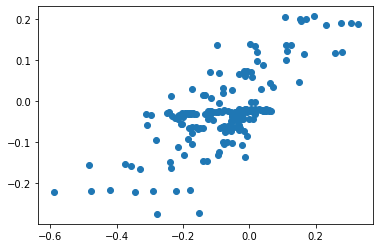

In [10]:
plt.plot(targets[500:], preds, 'o')

## Model formation energy with ElementProperty describer and Ridge regression 

In [11]:
from maml.describers import ElementProperty
from sklearn.linear_model import Ridge

model = SKLModel(describer=ElementProperty.from_preset('magpie'), 
                 model=Ridge(1e-2))

INFO:maml.describers.matminer_wrapper._matminer_wrapper:Using matminer_wrapper ElementProperty class


In [12]:
compositions = [i.composition for i in structures]

In [13]:
model.train(compositions[:500], targets[:500])

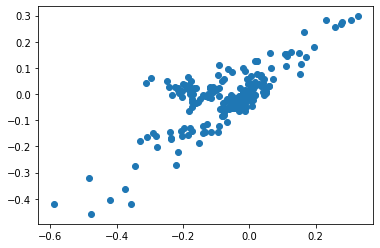

In [14]:
preds = model.predict_objs(compositions[500:])
plt.plot(targets[500:], preds, 'o')

## Model formation energy with DistinctSiteProperty describer and Multi-layer Perceptron

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from maml.models import KerasModel


k_model = Sequential()
k_model.add(Dense(128, input_dim=6, activation='relu'))
k_model.add(Dense(64, activation='relu'))
k_model.add(Dense(1))
k_model.compile('adam', 'mae')

model = KerasModel(describer=DistinctSiteProperty(wyckoffs=['12c', '12d', '8a'], 
                                                  properties=['atomic_radius', 'X']), 
                   model=k_model)

In [17]:
model.train(structures[:500], targets[:500], epochs=100)

Epoch 1/100
16/16 [==============================] - 0s 748us/step - loss: 0.1113
Epoch 2/100
16/16 [==============================] - 0s 639us/step - loss: 0.0695
Epoch 3/100
16/16 [==============================] - 0s 618us/step - loss: 0.0635
Epoch 4/100
16/16 [==============================] - 0s 590us/step - loss: 0.0610
Epoch 5/100
16/16 [==============================] - 0s 576us/step - loss: 0.0577
Epoch 6/100
16/16 [==============================] - 0s 640us/step - loss: 0.0551
Epoch 7/100
16/16 [==============================] - 0s 592us/step - loss: 0.0533
Epoch 8/100
16/16 [==============================] - 0s 570us/step - loss: 0.0541
Epoch 9/100
16/16 [==============================] - 0s 585us/step - loss: 0.0526
Epoch 10/100
16/16 [==============================] - 0s 566us/step - loss: 0.0566
Epoch 11/100
16/16 [==============================] - 0s 545us/step - loss: 0.0589
Epoch 12/100
16/16 [==============================] - 0s 594us/step - loss: 0.0498
Epoch 13/100


16/16 [==============================] - 0s 738us/step - loss: 0.0245
Epoch 100/100
16/16 [==============================] - 0s 582us/step - loss: 0.0244


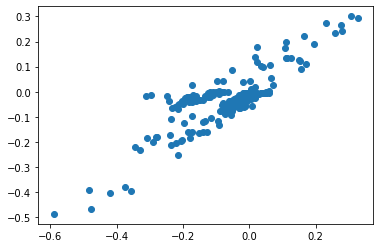

In [18]:
preds = model.predict_objs(structures[500:])
plt.plot(targets[500:], preds, 'o')